In [1]:
import altair as alt
from vega_datasets import data
# from altair import Chart, X, Y, Color, Text, Axis
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

import geopandas as gpd

In [2]:
city_sunshine_df = pd.read_csv('../data/sunshine.csv')
city_sunshine_df.head()

,city,month,month_num,temp_low,temp_high,precip_days,precip_inches,sunshine_hours,latitude,longitude
0,Seattle,Jan,0,37,47,18,5.55,69,47.608013,-122.335167
1,Seattle,Feb,1,37,50,14,3.46,108,47.608013,-122.335167
2,Seattle,Mar,2,39,54,16,3.70,178,47.608013,-122.335167
3,Seattle,Apr,3,42,58,14,2.68,207,47.608013,-122.335167
4,Seattle,May,4,47,65,12,1.93,253,47.608013,-122.335167


In [3]:
city_sunshine_gdf = gpd.GeoDataFrame(
    city_sunshine_df,
    geometry=gpd.points_from_xy(city_sunshine_df.longitude, city_sunshine_df.latitude),
    crs='EPSG:4326'
)

In [4]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)

not_lower_48_mask = states_gdf["NAME"].isin(["Alaska", "Hawaii", "Puerto Rico"])
lower_48_gdf = states_gdf[~not_lower_48_mask]

In [5]:
city_sunshine_extent = city_sunshine_gdf.total_bounds
city_sunshine_center_x = (city_sunshine_extent[0] + city_sunshine_extent[2])/2
city_sunshine_center_y = (city_sunshine_extent[3] + city_sunshine_extent[1])/2

aea_proj_str = f"""\
+proj=aea +lat_1={city_sunshine_extent[1]:.2f} \
+lat_2={city_sunshine_extent[3]:.2f} \
+lat_0={city_sunshine_center_y:.2f} \
+lon_0={city_sunshine_center_x:.2f}\
"""

In [6]:
lower_48_gdf = lower_48_gdf.to_crs(aea_proj_str)
city_sunshine_gdf = city_sunshine_gdf.to_crs(aea_proj_str)

In [7]:
city_sunshine_df.sunshine_hours.describe()

count     72.000000
mean     219.861111
std       65.514928
min       52.000000
25%      176.250000
50%      224.000000
75%      271.250000
max      330.000000
Name: sunshine_hours, dtype: float64

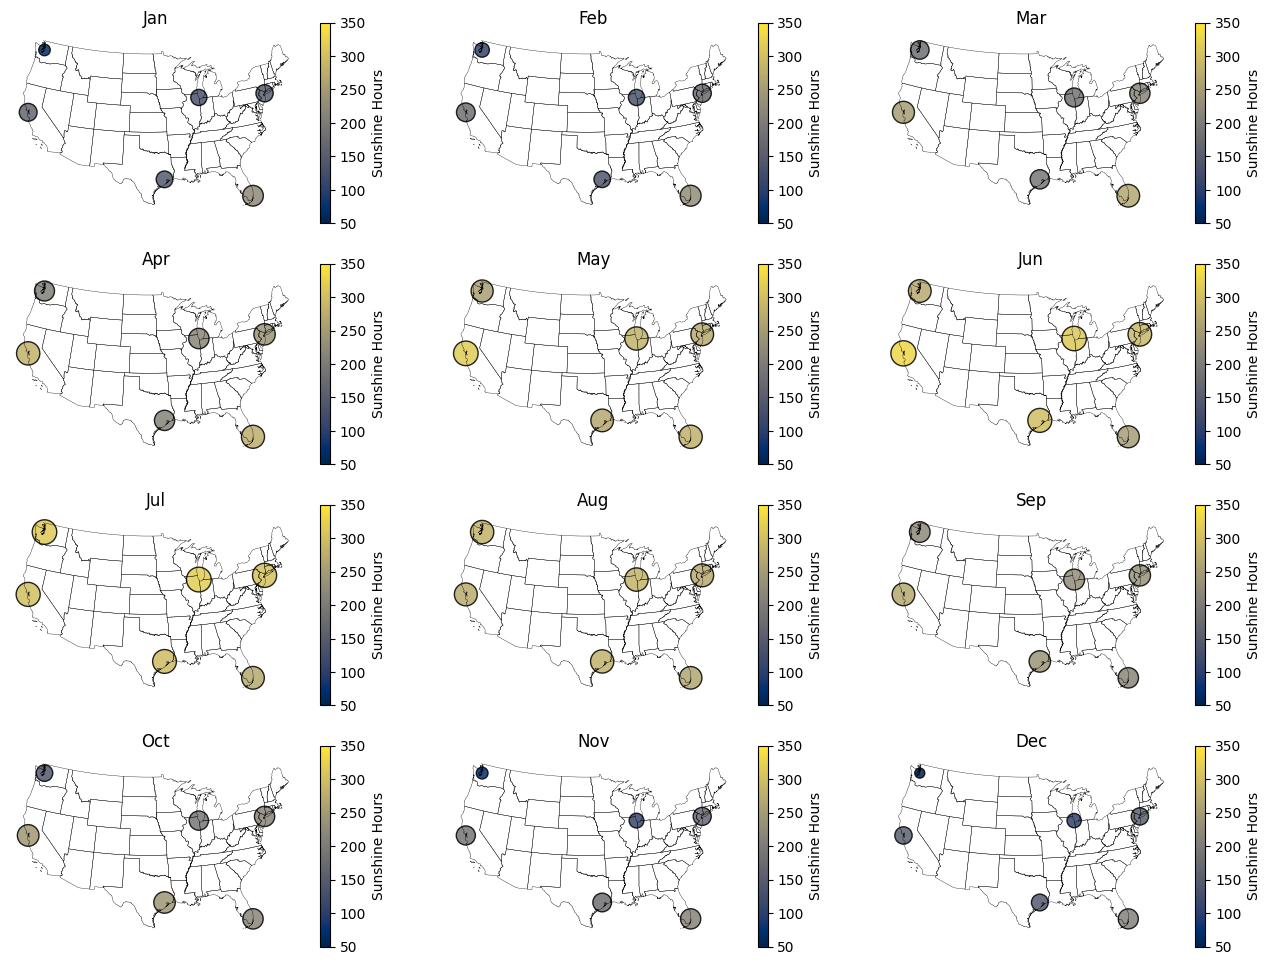

In [8]:
fig, axs = plt.subplots(4, 3, figsize=(16, 12))

for ax, month in zip(axs.flat, city_sunshine_df.month.unique()):
    lower_48_gdf.boundary.plot(ax=ax, linewidth=.25, color='black')
    city_sunshine_gdf_subset = city_sunshine_gdf.where(city_sunshine_gdf["month"] == month)
    city_sunshine_gdf_subset.plot(
        ax=ax, column='sunshine_hours', cmap='cividis', legend=True, legend_kwds={'label': "Sunshine Hours"}, markersize="sunshine_hours",
        vmin=50, vmax=350, alpha=0.85, edgecolor='black'
    )
    ax.set_title(f"{month}")

    ax.axis('off')
plt.show()

In [9]:
chart = alt.Chart(city_sunshine_df).mark_line().encode(
    alt.X(
        'month:O',
        axis=alt.Axis(
            title=None,
            labelAngle=0
        ),
        sort=alt.SortField('month_num')
    ),
    alt.Y(
        'sunshine_hours',
        axis=alt.Axis(title='Hours of Sunshine')
    ),
    alt.Color(
        'city',
        title='City',
        sort=alt.SortField(
            'sunshine_hours',
            order='descending'
        ),
    )
).properties(width=500)
chart

alt.Chart(...)

In [10]:
city_sunshine_gdf

,city,month,month_num,temp_low,temp_high,precip_days,precip_inches,sunshine_hours,latitude,longitude,geometry
0,Seattle,Jan,0,37,47,18,5.55,69,47.608013,-122.335167,POINT (-1796994.402 1452806.622)
1,Seattle,Feb,1,37,50,14,3.46,108,47.608013,-122.335167,POINT (-1796994.402 1452806.622)
2,Seattle,Mar,2,39,54,16,3.70,178,47.608013,-122.335167,POINT (-1796994.402 1452806.622)
3,Seattle,Apr,3,42,58,14,2.68,207,47.608013,-122.335167,POINT (-1796994.402 1452806.622)
4,Seattle,May,4,47,65,12,1.93,253,47.608013,-122.335167,POINT (-1796994.402 1452806.622)
...,...,...,...,...,...,...,...,...,...,...,...
67,Miami,Aug,7,77,91,16,8.88,263,25.761681,-80.191788,POINT (1795346.963 -1058675.056)
68,Miami,Sep,8,76,89,18,9.86,216,25.761681,-80.191788,POINT (1795346.963 -1058675.056)
69,Miami,Oct,9,74,86,15,6.33,215,25.761681,-80.191788,POINT (1795346.963 -1058675.056)
70,Miami,Nov,10,68,82,8,3.27,212,25.761681,-80.191788,POINT (1795346.963 -1058675.056)


In [11]:
states = alt.topo_feature(data.us_10m.url, feature='states')

In [12]:
background = alt.Chart(states).mark_geoshape(
    fill=None,
    stroke='k'
).project('albersUsa').properties(
    width=500,
    height=300
)
points = alt.Chart(city_sunshine_gdf.to_crs('EPSG:4326')).mark_geoshape(
    # stroke='black',
    # opacity=1
).encode(
    shape='geo:G',
    # x='longitude:Q',
    # y='latitude:Q',
    # color="sunshine_hours:Q",
    # alt.Color(
    #     'city',
    #     title='City',
    #     sort=alt.SortField(
    #         'sunshine_hours',
    #         order='descending'
    #     ),
    # ),
    size="sunshine_hours",
    # facet=alt.Facet(field='month', columns=3), # --> Need to work around the fact that this is a layered chart
).project('albersUsa')
# background + points
points

alt.Chart(...)

In [13]:
city_sunshine_gdf.sort_values('sunshine_hours', ascending=False).head(15)

,city,month,month_num,temp_low,temp_high,precip_days,precip_inches,sunshine_hours,latitude,longitude,geometry
17,San Francisco,Jun,5,47,60,11,4.46,330,37.733795,-122.446747,POINT (-2078116.316 378524.239)
30,Chicago,Jul,6,68,84,9,4.02,318,41.881832,-87.623177,POINT (862273.557 634309.521)
16,San Francisco,May,4,49,62,10,3.26,314,37.733795,-122.446747,POINT (-2078116.316 378524.239)
6,Seattle,Jul,6,56,76,5,0.67,312,47.608013,-122.335167,POINT (-1796994.402 1452806.622)
29,Chicago,Jun,5,63,81,10,4.06,311,41.881832,-87.623177,POINT (862273.557 634309.521)
54,New York,Jul,6,70,85,11,4.53,302,40.730610,-73.935242,POINT (1994709.287 706709.336)
18,San Francisco,Jul,6,46,57,11,4.50,300,37.733795,-122.446747,POINT (-2078116.316 378524.239)
41,Houston,Jun,5,72,90,8,3.82,298,29.749907,-95.358421,POINT (271138.776 -776358.171)
42,Houston,Jul,6,74,92,10,5.16,294,29.749907,-95.358421,POINT (271138.776 -776358.171)
53,New York,Jun,5,64,79,10,3.50,289,40.730610,-73.935242,POINT (1994709.287 706709.336)


In [14]:
city_sunshine_gdf.columns

Index(['city', 'month', 'month_num', 'temp_low', 'temp_high', 'precip_days',
       'precip_inches', 'sunshine_hours', 'latitude', 'longitude', 'geometry'],
      dtype='object')

In [15]:
my_chart = alt.Chart(
    city_sunshine_gdf, 
    title=alt.Title(
        ["How do the number of days of precipitation and the hours of ", "sunshine change throughout the year for 6 major US cities?"],
        fontSize=30,
        align='left',
        anchor='start',
        subtitle="This data comes from usclimatedata.com, which uses measurements averaged over the years 1981-2010.",
        subtitleFontSize=18,
    ),
).mark_circle(stroke='darkgray', opacity=1, width=.05).encode(
    x=alt.X(
        'month:O',
        axis=alt.Axis(title=None, labelAngle=-45, labelFontSize=16),
        sort=alt.SortField('month_num')
    ),
    y=alt.Y(
        'precip_days:Q',
        axis=alt.Axis(tickCount=6, title='Days of Precipitation', titleFontSize=16)
    ),
    color=alt.Color('sunshine_hours:Q', scale=alt.Scale(scheme="darkred"), title='Hours of Sunshine'),
    # size=alt.Size('sunshine_hours:Q', ),
    size=alt.value(200),
    facet=alt.Facet(
        field='city',
        columns=3,
        sort=alt.SortField('city'),
        title=None,
        header=alt.Header(labelFontSize=20)
    ),
).properties(
    width=350,
    height=200,
)
my_chart

alt.Chart(...)

In [16]:
my_chart.save('sunshine_precipitation.png', scale_factor=2.0)

#### Analysis of how I made this plot:

When considering the question of how the number of days of precipitation and the hours of sunshine change throughout the year for 6 major US cities, there were many graphical ways to answer this question. Some key elements I wanted to be sure were present in my visualization include a way to differentiate between cities, a means to determine what month a trend is taking place in, and of course the information about days of precipitation and hours of sunshine. The final design uses small multiples or faceting to convey different charts and their trends per city next to one another. This makes for easy visual comparison from city to city. Originally I was going to create this plot where the faceting was in terms of months and then each subplot contained information about precipitation versus sunshine hours where each point on the chart was a city. This was confusing to compare one city across each month because you had to remember which color it was and look for that color on each plot. In this final design it is relatively simple to glean information answering our question by looking at just one of the plots, and as an added bonus, one can compare this trend to other cities quite easily.

Furthermore, once I decided to facet with respect to the cities, I needed to determine how to present the information in each subplot. I was originally plotting precipitation days versus precipitation inches where each point was a month and sized by the hours of sunshine. This is problematic because it was odd to have a month be a single point losing the temporal ordering of the months. Additionally, this was overly complicated by plotting months, hours of sunshine, precip days, and precip inches with color, size, y-axis and x-axis respectively. I was definitely overplotting. Eliminating the precip inches information all together (after all it didn't contribute to answering the question at hand) freed up the x-axis to put the month information there. This created a nice temporal ordering for the information about days of precipitation.

At this point, I had determined the variable to facet with respect to, I had also determined which variables to plot along the x and y axes. Now I needed to determine if or how I would vary the color and size of the markers as well as any other stylistic choices for the chart. I initially liked conveying the hours of sunshine data by both the size and color shade (using a colormap) but to the viewer it was unclear and confusing to have one piece of information converted in two ways. This led to an overly complicated plot that muddled the quick interpretability of the data.
Therefore, I settled on only varying the color shade by the hours of sunshine and holding the size of the marker constant.

Finally, there were a few key minutia to highlight which improved the overall graphic. One, I added light grey edgecolor to the markers to help them stand out even when the color was fainter due to having more hours of sunshine that particular month. Two, I increased the number of ticks and gridlines for the y-axis to make it easy to compare the values of the points from city to city. Third, I increased the font sizes across the graphic to be appropriate according to their purpose but to always be large and readable. Fourth, In order to allow for more compact comparison, the faceting is in two rows of 3 columns, but to accommodate the compactness of this presentation the month names labeling the x-axis are angled at -45 degrees. Finally, I chose a colormap which conveys the reality that more sunshine hours would be brighter and lighter while less sunshine hours are darker. These last little details help bring the whole graphic together to easily answer the question at hand.


## HW Notes
* Feel free to add extra data but credit it and document it
* Write up less than or equal to 4 paragraphs
    - display design rational
    - why did you choose what you chose
* Use any visualization tool
* Create a repo and a README.md??
* Carefully Title your visual
    - perhaps use the guiding question or the answer to your guiding question
    - 
* Justify your decisions even if it doesn't match the `best practices`